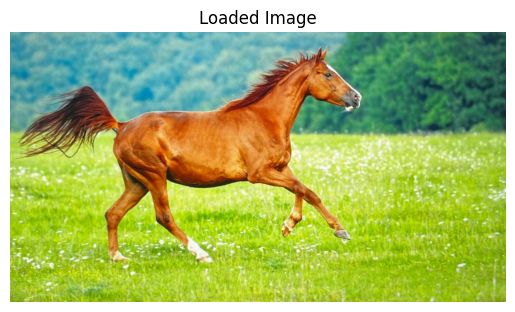

Image Shape: torch.Size([3, 698, 1280])


In [2]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# Load the image as a tensor
img = torchvision.io.read_image("/kaggle/input/bqidheq/Machine_learning.jpeg").float() / 255.0

# Check if the image has 4 channels (RGBA) and convert to RGB if necessary
if img.shape[0] == 4:
    img = img[:3, :, :]  # Use only RGB channels

# Display the image to ensure it's loaded correctly
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title("Loaded Image")
plt.axis('off')
plt.show()

# Print the shape of the image
print(f"Image Shape: {img.shape}")


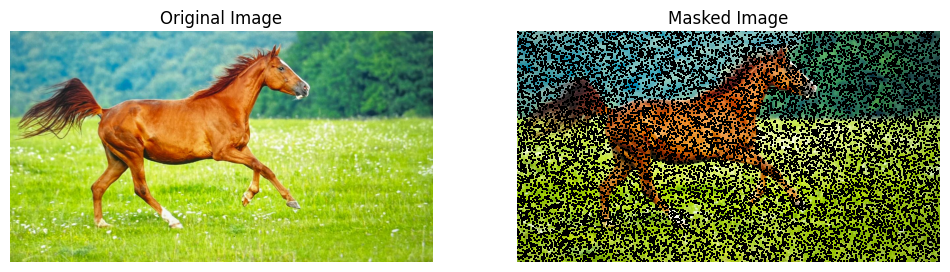

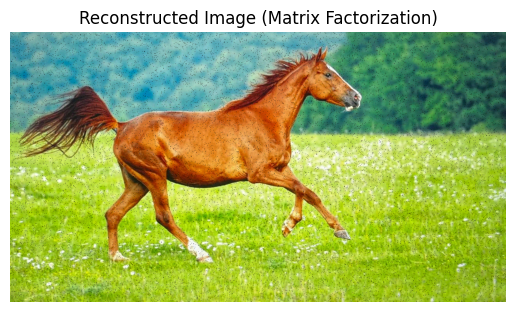

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to randomly mask a percentage of pixels in the image
def mask_random_pixels(image, mask_percentage=0.2):
    # image shape is [C, H, W], so we get height and width
    h, w = image.shape[1], image.shape[2]
    
    # Total number of pixels in one channel
    total_pixels = h * w
    
    # Randomly mask a percentage of the pixels
    num_pixels_to_mask = int(mask_percentage * total_pixels)
    masked_image = image.clone()

    # Randomly choose `num_pixels_to_mask` indices to mask
    random_indices = np.random.choice(total_pixels, num_pixels_to_mask, replace=False)

    # Mask these pixels in each channel
    for c in range(image.shape[0]):  # Iterate over channels (R, G, B)
        flat_channel = masked_image[c].view(-1)  # Flatten the channel
        flat_channel[random_indices] = float('nan')  # Mask the random pixels
        masked_image[c] = flat_channel.view(h, w)  # Reshape it back to original size

    return masked_image

# Function to apply matrix factorization (SVD / Gradient Descent)
def matrix_factorization(masked_img, rank, device):
    W = torch.randn(masked_img.shape[0], rank, device=device, requires_grad=True)
    H = torch.randn(rank, masked_img.shape[1], device=device, requires_grad=True)
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Gradient Descent to reconstruct the image
    for i in range(500):
        optimizer.zero_grad()
        pred = torch.mm(W, H)
        loss = criterion(torch.nan_to_num(masked_img), torch.nan_to_num(pred))
        loss.backward()
        optimizer.step()

    return W, H, loss.item()

# Load the image as a tensor
img = torchvision.io.read_image("/kaggle/input/bqidheq/Machine_learning.jpeg").float() / 255.0

# Check if the image has 4 channels (RGBA) and convert to RGB if necessary
if img.shape[0] == 4:
    img = img[:3, :, :]  # Use only RGB channels

# Mask a random percentage of pixels (e.g., 20%)
masked_img = mask_random_pixels(img, mask_percentage=0.02)

# Display the original and masked images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
ax[0].imshow(img.permute(1, 2, 0).numpy())
ax[0].set_title("Original Image")
ax[0].axis('off')

# Masked Image
ax[1].imshow(masked_img.permute(1, 2, 0).numpy())
ax[1].set_title("Masked Image")
ax[1].axis('off')

plt.show()

# Now we can proceed with matrix factorization on the masked image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rank = 2000  # Choose the rank for factorization

# Move the masked image to the device
masked_img_device = masked_img.to(device)

# Factorize each channel
W_r, H_r, loss_r = matrix_factorization(masked_img_device[0], rank, device)
W_g, H_g, loss_g = matrix_factorization(masked_img_device[1], rank, device)
W_b, H_b, loss_b = matrix_factorization(masked_img_device[2], rank, device)

# Reconstruct the image from W and H for each channel
reconstructed_r = torch.mm(W_r, H_r).cpu().detach().numpy()
reconstructed_g = torch.mm(W_g, H_g).cpu().detach().numpy()
reconstructed_b = torch.mm(W_b, H_b).cpu().detach().numpy()

# Stack the channels back together
reconstructed_img = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=0)

# Display the reconstructed image
plt.imshow(reconstructed_img.transpose(1, 2, 0))
plt.title("Reconstructed Image (Matrix Factorization)")
plt.axis('off')
plt.show()


RMSE: 0.08413887023925781
PSNR: 21.500066294135376 dB
